In [10]:
%pylab inline
from pyMouSh import MoulinShape, TimeStamps, Qin_constant, Qin_sinusoidal, Qin_real, calculate_h_S_schoof
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

Populating the interactive namespace from numpy and matplotlib


C:\Users\celia\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [19]:
secinday = 24*3600
ZERO_KELVIN = 273.15
#paramters

#temperature profile based of foxx data -- Lauren
tmp = pd.read_csv('Field_Data/temperature_foxx1.csv')
temperature_profile = tmp.temperature.to_numpy()#np.array([ZERO_KELVIN, ZERO_KELVIN])

moulin_radii = 0.2
initial_subglacial_area = 1 
regional_surface_slope = 0.01
channel_length = 25e3
ice_thickness = 500
initial_head = ice_thickness

#Import meltwater input calculated with meltmodel for JEME
jeme_basin = pd.read_csv('Field_Data/surface_melt_jeme.csv')
jeme_basin = jeme_basin.dropna()
Qin_data = jeme_basin.Qm3s.to_numpy() +0.1
Qtime_data = jeme_basin.SOY.to_numpy() + 3*3600 #add routing delay -- Jess found 2h not 4. investigate why

#Import head measurement for JEME
jeme_moulin = pd.read_csv('Field_Data/head_jeme.csv')
jeme_moulin = jeme_moulin.dropna()
h_real = jeme_moulin.head_bed.to_numpy()
t_real = jeme_moulin.soy.to_numpy()

#set timeserie length and timestep for interpolation
time_start = Qtime_data[int(2*secinday/900)]  
time_end = time_start + 60*secinday
timestep = 30*60#300 #seconds to reduce number of saved data
time = TimeStamps(time_start,time_end,timestep)

#calculate meltwater input (interpolate)
meltwater_input = Qin_real(time, Qin_data, Qtime_data)

#calculate baseflow
bf_mean = 1
bf_amp = 0.1 
shift0h = 0.42 * secinday
shift12h = 0 * secinday # sin is already shifted from input
baseflow_shift0 = Qin_sinusoidal(time,bf_mean, bf_amp, shift=shift0h)
baseflow_shift12 = Qin_sinusoidal(time,bf_mean, bf_amp, shift=shift12h)



In [12]:
def plot_data(moulin_sim,t_real,h_real,idx=-1,
             Q_lim=[0.1,0.5], radius_lim=[0,1]):
    
    fig = plt.figure(figsize=(13,5))   
    grid = plt.GridSpec(4,3)#, wspace=-0.7)
    
    ax1b = fig.add_subplot(grid[0, 0:2])#Qin
    ax1a = ax1b.twinx()
    ax2 = fig.add_subplot(grid[1:4, 2])#moulin
    ax3 = fig.add_subplot(grid[1:4, 0:2])#hw
    ax4 = fig.add_subplot(grid[3, 0:2])#SCs  

    ax1a.yaxis.set_label_coords(1.15, 0.7)
    ax1b.yaxis.set_label_coords(-0.065, 0.5)
    ax3.yaxis.set_label_coords(-0.08, 0.7)
    ax4.yaxis.set_label_coords(-0.08, 0.5)
    
    ground_depth=-60
    spine_head_min=200
    lw=1.5
    
    #baseflow
    moulin_sim.plot_baseflow(ax1a,
                       color='seagreen',
                       bottom_axis=False,
                       axis_side = 'right') 
    #ax1a.set_xlim(t_lim) 

    #Meltwater
    moulin_sim.plot_Qin(ax1b,
                   bottom_axis=False,
                   axis_side = 'left',
                   color='grey') 
    #ax1b.set_xlim(t_lim) 
    ax1b.set_ylim(Q_lim)


    #Moulin
    moulin_sim.plot_moulin(ax2,idx,
                     left_lim = -5,
                     left_bound = -4,
                     right_lim = 5,
                     right_bound = 4,
                     x_tick_spacing = 2,
                     ground_depth=ground_depth,
                     axis_side = 'right',)

    #Head
    ax3.plot(t_real/3600/24,h_real,'-',color='black') 
    moulin_sim.plot_head(ax3,
                   color='steelblue',
                   spine_head_min = spine_head_min,
                   bottom_axis = False,
                   axis_side = 'left',
                   ground_depth = ground_depth) 

    #ax3.set_xlim(t_lim)


    #Subglacial radius
    moulin_sim.plot_subglacial_radius(ax4,
                               color='orangered',
                               bottom_axis=True,
                               axis_side = 'left')         
    #ax4.set_xlim(t_lim)
    #ax4.tick_params(axis='x',labelsize=8)
    ax4.set_ylim(radius_lim)
    #ax4.spines['bottom'].set_bounds(t_lim[0]+0.1,t_lim[1])
    ax4.set_xlabel('Days')


    #Legend 
    size_legend=10
    l1a = ax1a.legend(['Subglacial baseflow'],
                      loc="upper left", bbox_to_anchor=(0.7, 1.1), prop={'size': size_legend})  
    for line, text in zip(l1a.get_lines(), l1a.get_texts()):
        text.set_color(line.get_color())  
    l1b = ax1b.legend(['Meltwater input'],
                      loc="upper left", bbox_to_anchor=(0, 1.1), prop={'size': size_legend})
    for line, text in zip(l1b.get_lines(), l1b.get_texts()):
        text.set_color(line.get_color())  
    l3 = ax3.legend(['Head measured','Head simulated'],
                    loc="upper left", bbox_to_anchor=(0, 1), prop={'size': size_legend})    
    for line, text in zip(l3.get_lines(), l3.get_texts()):
        text.set_color(line.get_color())
    l4 = ax4.legend(['Subglacial radius'],
                    loc="upper left", bbox_to_anchor=(0, 1.1), prop={'size': size_legend})
    for line, text in zip(l4.get_lines(), l4.get_texts()):
        text.set_color(line.get_color())
    ax4.patch.set_alpha(0)

    #thicker axis
    for axis in ['top','bottom','left','right']:
        ax1a.spines[axis].set_linewidth(lw)
    ax1a.tick_params(width=lw)
    
    for axis in ['top','bottom','left','right']:
        ax1b.spines[axis].set_linewidth(lw)
    ax1b.tick_params(width=lw)

    for axis in ['top','bottom','left','right']:
        ax2.spines[axis].set_linewidth(lw)
    ax2.tick_params(width=lw)

    for axis in ['top','bottom','left','right']:
        ax3.spines[axis].set_linewidth(lw)
    ax3.tick_params(width=lw)

    for axis in ['top','bottom','left','right']:
        ax4.spines[axis].set_linewidth(lw)
    ax4.tick_params(width=lw)
        




   

## Calculate timeseries

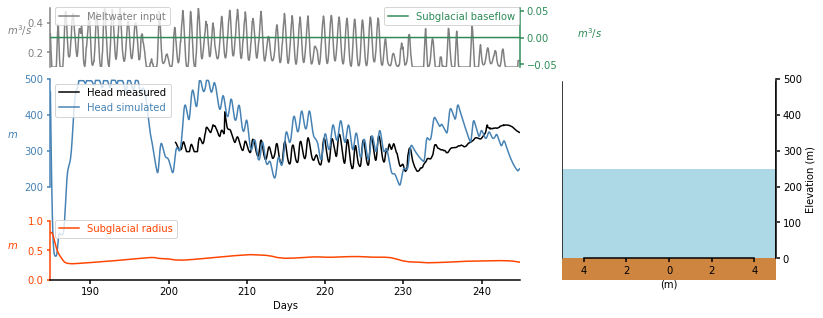

In [13]:
cylinder = MoulinShape(moulin_radii = 5.,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    cylinder.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    creep=False,
                    elastic_deformation=False,
                    melt_below_head=False,
                    open_channel_melt=False,
                    potential_drop=False,
                    ice_motion=False,
                    refreezing=False)
    
plot_data(cylinder,t_real,h_real)
plt.savefig('cylinder.pdf')

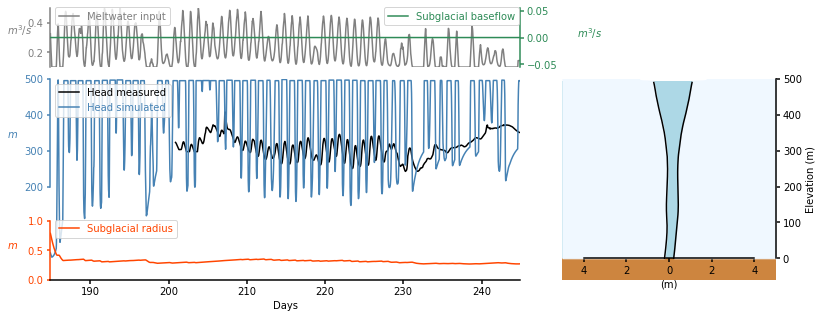

In [14]:
bf0_fix = MoulinShape(moulin_radii = moulin_radii,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    bf0_fix.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    subglacial_baseflow = 0)
    
plot_data(bf0_fix,t_real,h_real)
plt.savefig('bf0_fix.pdf')

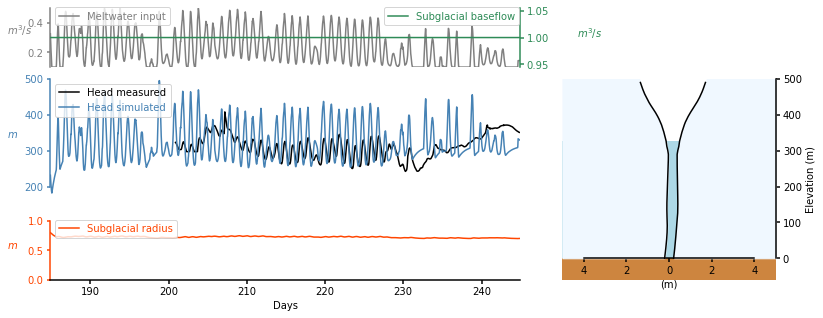

In [15]:
bf1_fix = MoulinShape(moulin_radii = moulin_radii,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    bf1_fix.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    subglacial_baseflow = 1)
    
plot_data(bf1_fix,t_real,h_real)
plt.savefig('bf1_fix.pdf')

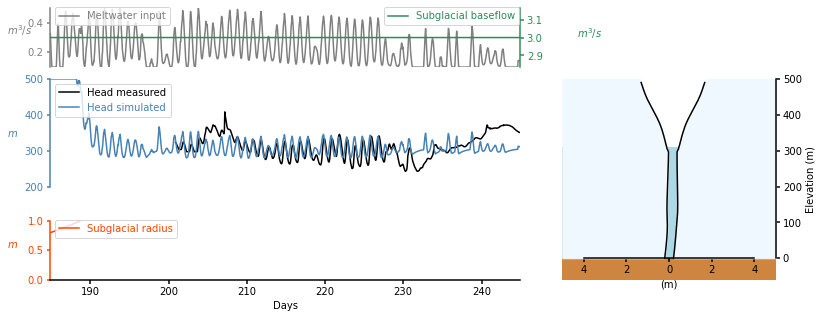

In [16]:
bf3_fix = MoulinShape(moulin_radii = moulin_radii,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    bf3_fix.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    subglacial_baseflow = 3)
    
    
plot_data(bf3_fix,t_real,h_real)
plt.savefig('bf3_fix.pdf')

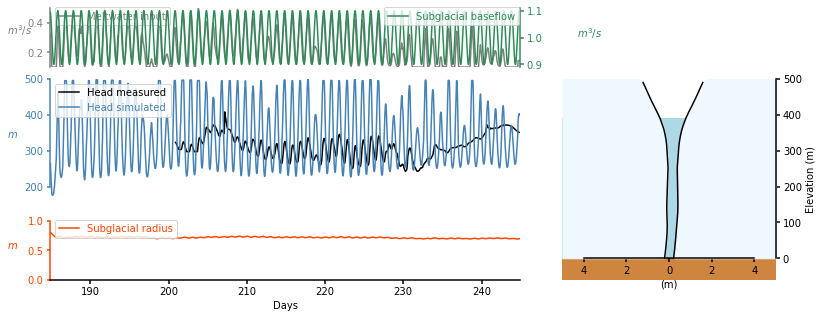

In [17]:
bf1_osc = MoulinShape(moulin_radii = moulin_radii,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    bf1_osc.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    subglacial_baseflow = baseflow_shift0[idx])
    
    
plot_data(bf1_osc,t_real,h_real)
plt.savefig('bf1_osc.pdf')

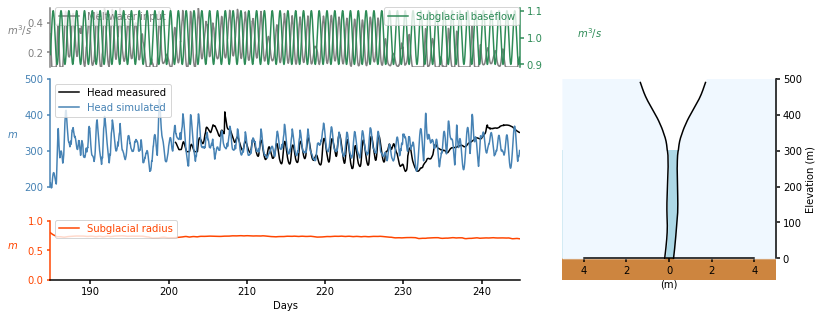

In [18]:
bf1_osc_shift = MoulinShape(moulin_radii = moulin_radii,
                      ice_thickness = ice_thickness,
                      initial_head = initial_head,
                      initial_subglacial_area = initial_subglacial_area,
                      channel_length = channel_length,
                      regional_surface_slope = regional_surface_slope,
                      temperature_profile = temperature_profile)

for idx,t in enumerate(time) :
    bf1_osc_shift.run1step(t,
                    timestep,
                    meltwater_input[idx],
                    subglacial_baseflow = baseflow_shift12[idx])
    
plot_data(bf1_osc_shift,t_real,h_real)
plt.savefig('bf1_osc_shift.pdf')